In [1]:
import os
import sys

if 'google.colab' in sys.modules:       # Si on est dans Google Colab
    # Colab : Monter Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    project_path = '/content/drive/MyDrive/internship_cvut'
else:
    # Exécution locale : on se base sur le chemin du fichier
    project_path = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..'))

# Changer le dossier courant vers le dossier du projet
os.chdir(project_path)

# Ajouter src/ au path si nécessaire
src_path = os.path.join(project_path, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

# Optionnel : vérifier que tout est bien configuré
# print("Répertoire courant :", os.getcwd())
# print("Contenu de src :", os.listdir(src_path))
# print("Contenu de database :", os.listdir(os.path.join(project_path, 'database')))

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

from python_scripts.miscellaneaous.data_processing import extract_data
from python_scripts.road_detection.road_utils import *

#### Fonctionnement



**But** : Détecter des chaînes de triplets (presque) alignés

1. Pour chaque station, on cherche deux voisines qui :

    - sont assez proches ( < *max_dist* m)

    - forment un angle presque plat (0 ou 180°, tolérance de *angle_max*)

2. On regarde si ces alignements peuvent être étendus en concaténant les triplets

3. On filtre les vraies routes

    - Longueur minimale de chaîne (ex. ≥ 1km ou ≥ 5 stations)

    - *non implémenté* : Pas trop de virages brutaux  

    - *non implémenté* : Faible densité transversale (≠ ville)

#### Méthode de base

/tmp/ipython-input-3993469222.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("database/data.csv", sep=";", decimal=',')


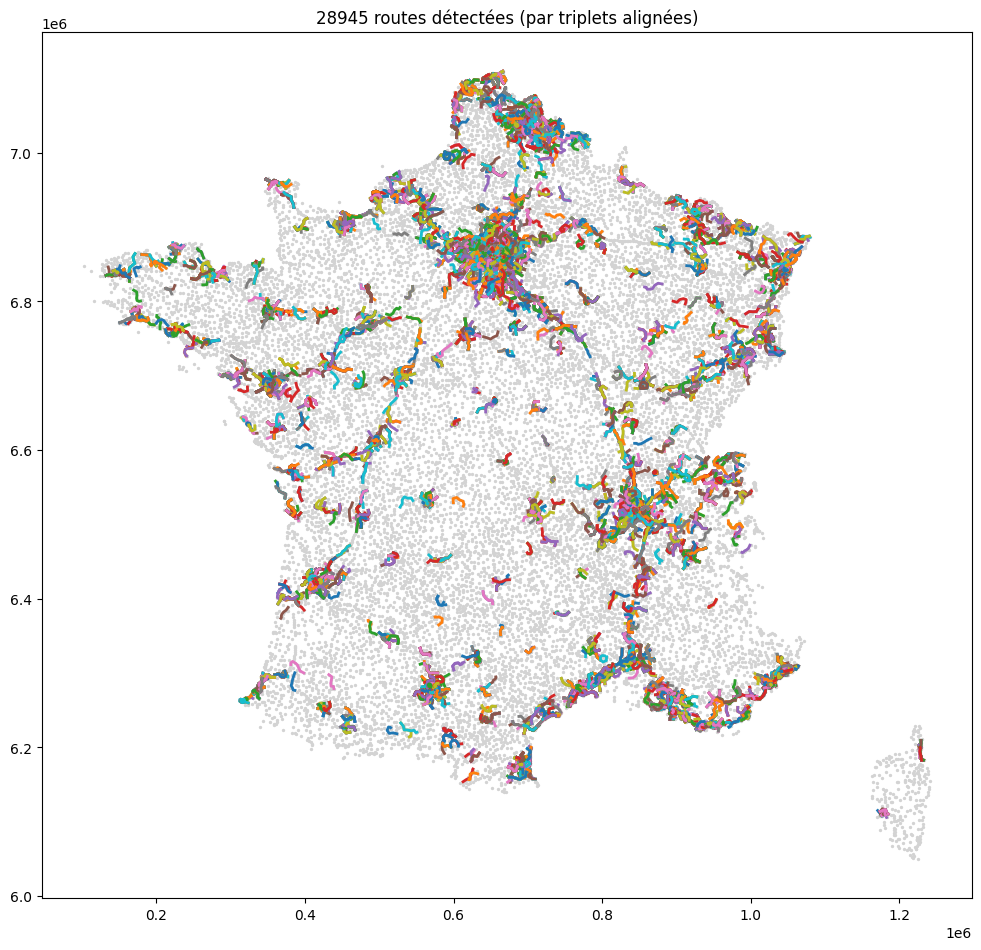

🔹 Nombre de chaînes trouvées :  28945
🔹 Longueur moyenne des chaînes : 14.239 km
🔹 Écart-type longueur des chaînes : 7.894 km
🔹 Longueur moyenne des chaînes : 8.4 stations
🔹 Écart-type longueur des chaînes : 1.78

🔹 Évaluation globale :
Longueur détectée : 412152.5 km
Longueur réelle (référence) : 432680.0 km
Erreur absolue : 20527.5 km
Erreur relative : 4.74%

🔹 Évaluation par département :
          Département  Réel (km)  Détecté (km)  Erreur (km)  \
19              Paris         73        6684.9       6611.9   
60  Seine-Saint-Denis        178        7677.2       7499.2   
65       Val-de-Marne        183        7641.8       7458.8   
59    Alpes-Maritimes        252        9965.5       9713.5   
50     Hauts-de-Seine        155        5920.1       5765.1   

   Erreur relative (%)  
19             9057.4%  
60             4213.0%  
65             4075.8%  
59             3854.6%  
50             3719.4%  

Écart-type des erreurs départementales : 12.903
Max erreur relative d’un dé

{'Erreur absolue (km)': np.float64(20527.5),
 'Erreur relative globale': np.float64(0.047),
 'Écart-type erreurs relatives dép.': np.float64(12.903),
 'Max erreurs relatives dép.': np.float64(90.574),
 'Nb départements à forte erreur': 82,
 'Taux de redondance (≈doublons)': 0.0}

In [3]:
# Chargement des données
df = pd.read_csv("database/data.csv", sep=";", decimal=',')
df = extract_data(df, provider='Orange') #, techno='4g')#, region='Normandie')

xy = df[['x', 'y']].to_numpy()
departements = df['nom_dep']

# Paramètres
k = 10                    # nb de voisins à considérer
angle_threshold = 80      # tolérance angulaire (plus petit = plus plat)
min_chain_length = 7      # nb de stations minimum dans une "route"
max_dist = 5500           # distance max entre points voisins (en mètres)

# Application
chains = detect_chains_by_triplets(xy, k, angle_threshold, min_chain_length, max_dist)

affichage_chains(xy, chains, title = f"{len(chains)} routes détectées (par triplets alignées)")

#evaluate_chain_detection(xy,chains)

ref_total_length = (
    df_routes['Autoroutes'].sum() +
    df_routes['Routes nationales'].sum() +
    # df_routes['Routes départementales et voies communales'].sum() +
     382491 +    # Routes départementales, d'après statista
    # 714,883 +  # Routes communales, d'après statista
    df_chemin_fer['long_ferre'].sum()
)
compute_chain_metrics(xy, chains, departements, ref_total_length)

#### Amélioration 1

Prolonge les chaînes en considérant le meilleur candidat, pas avec les triplets existants

Construit des chaînes sans exclure les points déjà utilisés (station peut appartenir à plusieurs routes)

/tmp/ipython-input-3193160439.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("database/data.csv", sep=";", decimal=',')


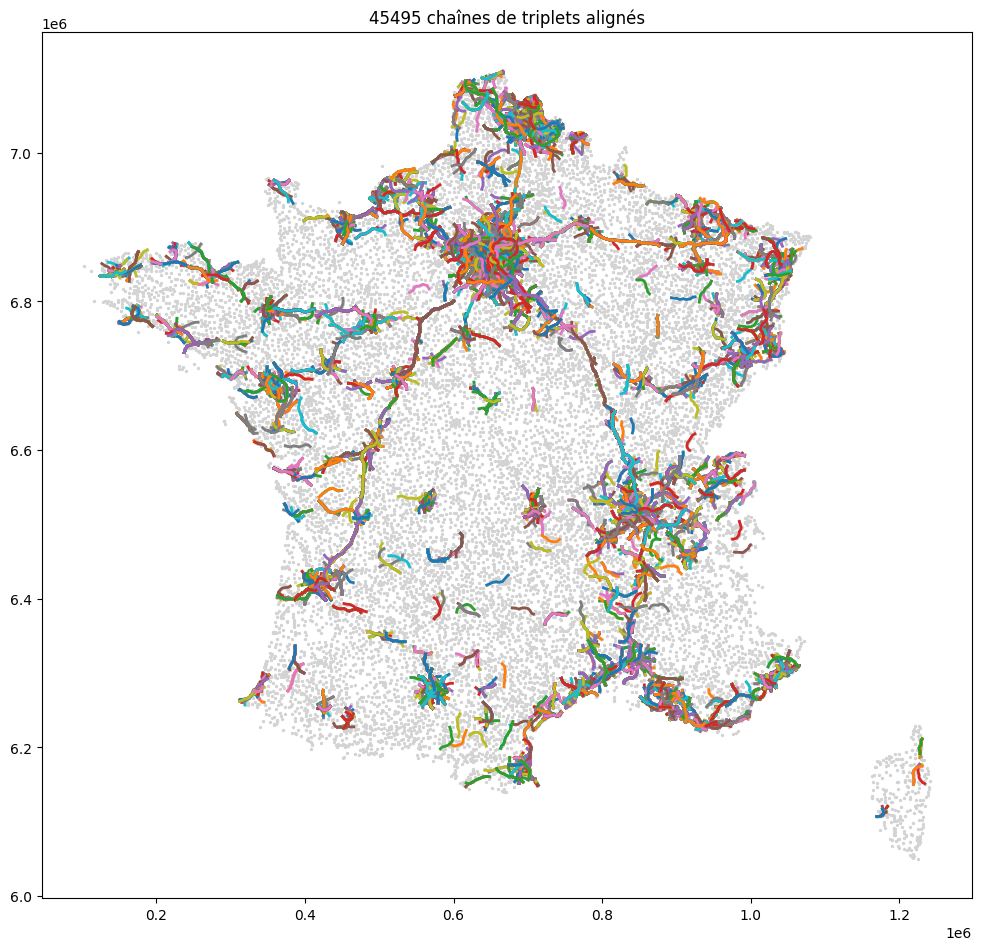

Nombre de chaînes trouvées :  45495
🔹 Longueur moyenne des chaînes : 29567.91368720566
🔹 Écart-type longueur des chaînes : 22678.982

🔹 Évaluation globale :
Longueur détectée : 1345192.2 km
Longueur réelle (référence) : 432680.0 km
Erreur absolue : 912512.2 km
Erreur relative : 210.90%

🔹 Évaluation par département :
          Département  Réel (km)  Détecté (km)  Erreur (km)  Erreur relative  \
62              Paris         73       52963.1      52890.1       724.522270   
90       Val-de-Marne        183       48010.9      47827.9       261.354684   
67  Seine-Saint-Denis        178       45583.8      45405.8       255.088549   
93            Essonne        365       93050.0      92685.0       253.931498   
16     Hauts-de-Seine        155       34667.3      34512.3       222.659969   

   Erreur relative (%)  
62            72452.2%  
90            26135.5%  
67            25508.9%  
93            25393.1%  
16            22266.0%  

🔹 Écart-type des erreurs départementales : 88.520

{'Erreur absolue (km)': np.float64(912512.2),
 'Erreur relative globale': np.float64(2.109),
 'Écart-type erreurs relatives dép.': np.float64(88.52),
 'Max erreurs relatives dép.': np.float64(724.522),
 'Nb départements à forte erreur': 91,
 'Taux de redondance (≈doublons)': 0.425}

In [ ]:
# Données
df = pd.read_csv("database/data.csv", sep=";", decimal=',')
df = extract_data(df, provider='Orange') #, region='Nouvelle-Aquitaine')
xy = df[['x', 'y']].to_numpy()
departements = df['nom_dep']

# Paramètres
k = 10                    # Nombre de voisins pour chercher des triplets initiaux
angle_max = 40            # Tolérance d'alignement entre 3 points de départ
angle_max_ext = 40        # Tolérance d'alignement pour étendre la chaîne
dist_max = 5500           # Distance max entre points pour étendre la chaîne
min_chain_len = 9         # Longueur minimale de la chaîne


chains = detect_chains_by_triplets_enhanced(xy, k, angle_max, angle_max_ext, dist_max, min_chain_len)

affichage_chains(xy, chains, title = f"{len(chains)} chaînes de triplets alignés")

#evaluate_chain_detection(xy,chains)

ref_total_length = (
    df_routes['Autoroutes'].sum() +
    df_routes['Routes nationales'].sum() +
    # df_routes['Routes départementales et voies communales'].sum() +
     382491 +    # Routes départementales, d'après statista
    # 714,883 +  # Routes communales, d'après statista
    df_chemin_fer['long_ferre'].sum()
)
compute_chain_metrics(xy, chains, departements, ref_total_length)

#### Amélioration 2

Fusion des chaînes proches et suffisamment alignées.


2162 → 1931 chaînes fusionnées


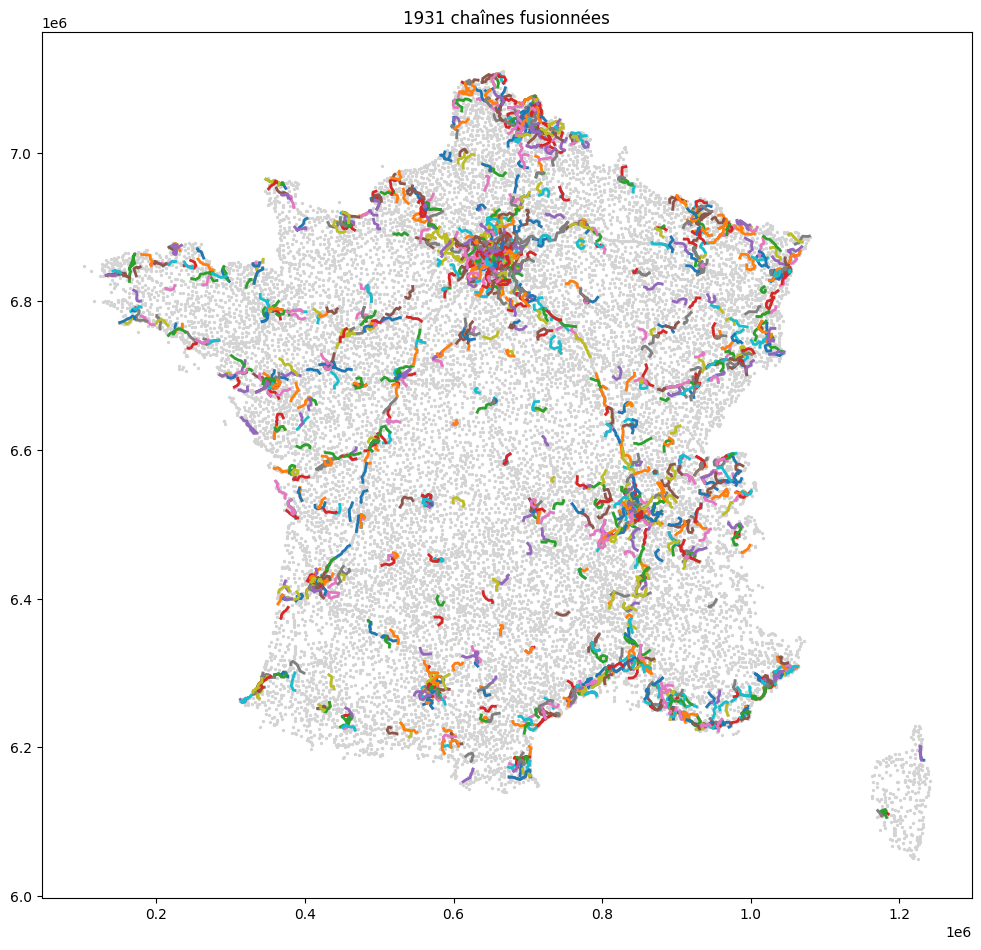

Longueur détectée : 36012.7 km
Longueur réelle (référence) : 432680.0 km
Erreur absolue : 396667.3 km
Erreur relative : 91.68%


(np.float64(396667.3286408169), np.float64(0.9167683476028865))

In [ ]:
# --- Fusion de chaînes ---

fusion_dist_thresh = 1000     # Distance max entre extrémités
fusion_angle_thresh = 25     # Tolérance sur l'alignement (en degrés autour de 180°)

chains_fused = fuse_all_chains(chains, xy, fusion_angle_thresh, fusion_dist_thresh)
print(f"{len(chains)} → {len(chains_fused)} chaînes fusionnées")

affichage_chains(xy, chains_fused, title = f"{len(chains_fused)} chaînes fusionnées")

evaluate_chain_detection(xy,chains_fused)